# Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv('../../input/feedback-prize-effectiveness/train.csv')
stack_df = pd.read_csv('../../99_Ensemble/99_v1_02/result/stack_99_v1_02_22.csv')

train_df = train_df[['discourse_id']].merge(stack_df, on='discourse_id', how='left')
print(train_df.shape)
train_df.head()

(36765, 25)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Effective_2,Ineffective_3,Adequate_3,Effective_3,Ineffective_4,Adequate_4,Effective_4,Ineffective,Adequate,Effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.002610,0.183576,0.013815,1,0.085691,...,0.008075,0.002195,0.193195,0.004610,0.015633,0.179762,0.004605,0.037435,0.922885,0.039680
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.011199,0.183275,0.005526,1,0.087332,...,0.005189,0.023476,0.168711,0.007814,0.010395,0.185975,0.003630,0.078403,0.894195,0.027401
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.028142,0.169630,0.002228,1,0.164698,...,0.003615,0.010394,0.183001,0.006605,0.035390,0.163083,0.001527,0.148400,0.835695,0.015905
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.066880,0.131394,0.001727,1,0.420119,...,0.002774,0.025666,0.171699,0.002635,0.039214,0.159075,0.001711,0.216103,0.772698,0.011199
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.049548,0.149608,0.000844,1,0.290297,...,0.002079,0.045025,0.152621,0.002354,0.065161,0.133572,0.001267,0.295933,0.696302,0.007765


# Features

# Data Split

In [2]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v2_07/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [3]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [4]:
cols = []
for col_name in ['Ineffective','Adequate','Effective']:
    cols += [col for col in train_df.columns if (col.startswith(col_name) and '_' in col)] 
    
num_models = len(cols) // 3
num_models

5

In [5]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiClass',
    #'eval_metric':'MultiClass'
}

fold0 : CV=0.5725


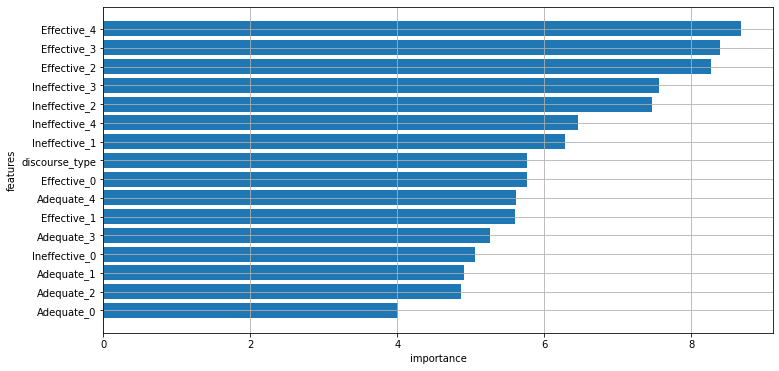

fold1 : CV=0.5868


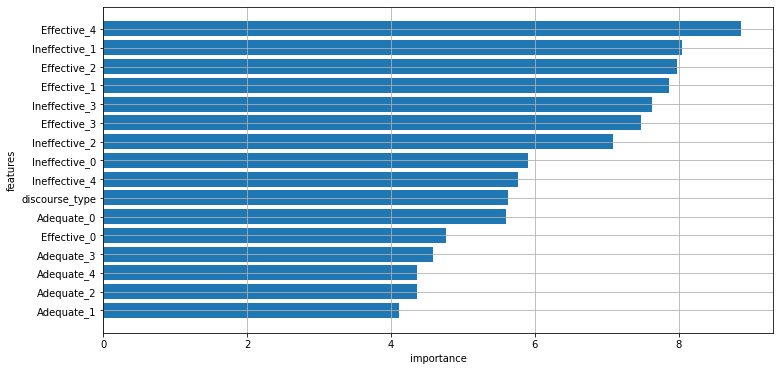

fold2 : CV=0.5718


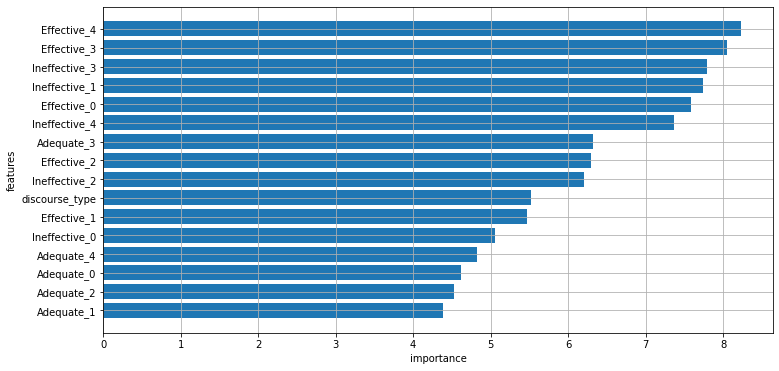

fold3 : CV=0.5907


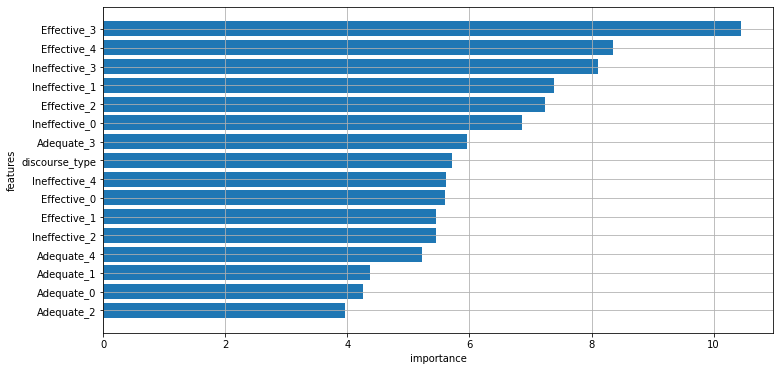

fold4 : CV=0.5805


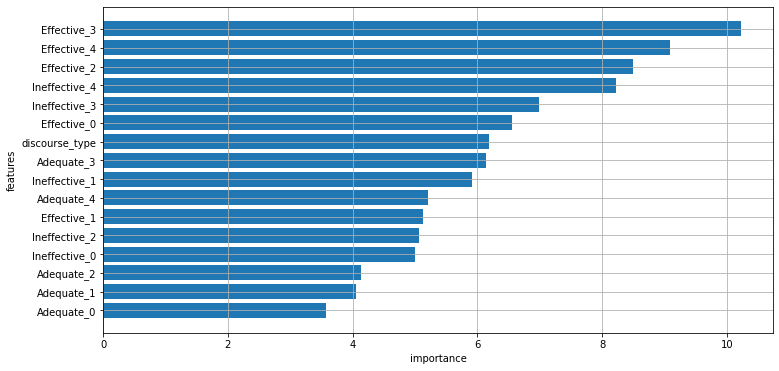

CV=0.5805


In [6]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cols = ['discourse_type'] + cols
cat_features = [0]

score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['essay_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[cols].values, label=trn_df['label'].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[cols].values, label=val_df['label'].values, cat_features=cat_features)

    model = catboost.CatBoostClassifier(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val, prediction_type='Probability')
    target = val_df['label'].values
    score = log_loss(target, pred, labels=[0,1,2])
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    val_df['oof_ineffective'] = pred[:,0]
    val_df['oof_adequate'] = pred[:,1]
    val_df['oof_effective'] = pred[:,2]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [7]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['discourse_id']].merge(oof_df, on='discourse_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(36765, 28)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Effective_3,Ineffective_4,Adequate_4,Effective_4,Ineffective,Adequate,Effective,oof_ineffective,oof_adequate,oof_effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.002610,0.183576,0.013815,1,0.085691,...,0.004610,0.015633,0.179762,0.004605,0.037435,0.922885,0.039680,0.040279,0.909830,0.049892
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.011199,0.183275,0.005526,1,0.087332,...,0.007814,0.010395,0.185975,0.003630,0.078403,0.894195,0.027401,0.107744,0.855748,0.036508
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.028142,0.169630,0.002228,1,0.164698,...,0.006605,0.035390,0.163083,0.001527,0.148400,0.835695,0.015905,0.164529,0.814616,0.020854
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.066880,0.131394,0.001727,1,0.420119,...,0.002635,0.039214,0.159075,0.001711,0.216103,0.772698,0.011199,0.264946,0.723377,0.011677
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.049548,0.149608,0.000844,1,0.290297,...,0.002354,0.065161,0.133572,0.001267,0.295933,0.696302,0.007765,0.274220,0.719837,0.005943


In [8]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = log_loss(oof_df['label'].values, oof_df[cols].values, labels=[0,1,2])
print('oof={:.4f}'.format(oof_score))

oof=0.5805
